<a href="https://colab.research.google.com/github/solidjoe/my-python-app/blob/main/Hindi_Factivity_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os

INPUT_FILE = '/content/Hindi_Experiment_Data.xlsx'
OUTPUT_FILE = 'Hindi_Transformed_Data_Final.xlsx'

def process_hindi_experiment(input_path, output_path):
    if not os.path.exists(input_path):
        print(f"❌ Error: {input_path} not found.")
        return

    print(f"Reading file: {input_path}...")

    # 1. LOAD DATA
    if input_path.endswith('.csv'):
        try:
            df = pd.read_csv(input_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(input_path, encoding='latin1')
    else:

        df = pd.read_excel(input_path)

    # 2. FILTERING: Keep only complete sessions (12 rows per block)
    session_groups = ['Participant_ID', 'Task_Block']
    counts = df.groupby(session_groups).size().reset_index(name='Row_Count')
    valid_sessions = counts[counts['Row_Count'] == 12]

    df_filtered = pd.merge(df, valid_sessions[session_groups], on=session_groups, how='inner')

    # 3. TRANSFORMATIONS
    df_filtered['Rating_Normalized'] = df_filtered['Rating'] / 100.0
    N = len(df_filtered)
    df_filtered['Rating_Beta'] = (df_filtered['Rating_Normalized'] * (N - 1) + 0.5) / N

    # 4. FORMATTING
    target_cols = ['Timestamp', 'Participant_ID', 'Verb', 'Verb_Type',
                   'Task_Block', 'Rating', 'Rating_Normalized', 'Rating_Beta']
    final_df = df_filtered[[col for col in target_cols if col in df_filtered.columns]]

    # 5. OUTPUT AS EXCEL

    final_df.to_excel(output_path, index=False)

    print(f"✅ Success! Excel file saved as: {output_path}")

if __name__ == "__main__":
    process_hindi_experiment(INPUT_FILE, OUTPUT_FILE)

Reading file: /content/Hindi_Experiment_Data.xlsx...
✅ Success! Excel file saved as: Hindi_Transformed_Data_Final.xlsx


In [1]:
import pandas as pd
import numpy as np

# 1. LOAD THE DATA

FILE_PATH = '/content/Hindi_Transformed_Data_Final.xlsx'

try:

    df = pd.read_excel(FILE_PATH)
    print("✅ File loaded successfully.\n")
except Exception as e:
    print(f"❌ Error: Could not find or read the file. {e}")

    raise

#  2. CALCULATE SD PER SESSION
# This calculates the Standard Deviation of the 'Rating' for each block (12 items)
session_variances = df.groupby(['Participant_ID', 'Task_Block'])['Rating'].std().reset_index()
session_variances.columns = ['Participant_ID', 'Task_Block', 'Response_SD']

#  3. CALCULATE GROUP METRICS
# We find the average 'volatility' of the whole group
group_mean = session_variances['Response_SD'].mean()
group_std  = session_variances['Response_SD'].std()

# 4. DEFINE THE ZOMBIE THRESHOLD
# Logic: 3 Standard Deviations below the mean (searching for 'flatliners')
threshold = group_mean - (3 * group_std)

print(f"📊 Average Participant SD: {group_mean:.2f}")
print(f"📊 Group SD of Variances: {group_std:.2f}")
print(f"🚫 Zombie Threshold (3SD below mean): {threshold:.2f}")
print("-" * 30)

#  5. IDENTIFY THE ZOMBIES
zombies = session_variances[session_variances['Response_SD'] < threshold]

if len(zombies) > 0:
    print(f"🧟 Found {len(zombies)} Zombie Session(s):")
    print(zombies)
else:
    print("✅ No Zombies found! All participants moved the sliders sufficiently.")

# Optional: Show the top 5 most 'consistent' (potential low variance) participants
print("\n🔍 Most 'Flat' Responders (Lowest SD):")
print(session_variances.sort_values(by='Response_SD').head())

✅ File loaded successfully.

📊 Average Participant SD: 24.80
📊 Group SD of Variances: 18.53
🚫 Zombie Threshold (3SD below mean): -30.78
------------------------------
✅ No Zombies found! All participants moved the sliders sufficiently.

🔍 Most 'Flat' Responders (Lowest SD):
    Participant_ID    Task_Block  Response_SD
9             2143    Projection          0.0
8             2143  At-issueness          0.0
30            5370  At-issueness          0.0
31            5370    Projection          0.0
50            9139  At-issueness          0.0


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 1. Load Data
df = pd.read_csv('Hindi_Transformed_Data_1.csv')

# 2. Individual Trial Correlation (276 pairs)
df_paired = df.pivot_table(index=['Participant_ID', 'Verb'],
                          columns='Task_Block',
                          values='Rating_Normalized').dropna()

r_trial, p_trial = pearsonr(df_paired['At-issueness'], df_paired['Projection'])

# 3. Aggregated Verb Correlation (12 verbs)
verb_means = df.groupby(['Verb', 'Task_Block'])['Rating_Normalized'].mean().unstack()

r_agg, p_agg = pearsonr(verb_means['At-issueness'], verb_means['Projection'])

# --- ADD THESE PRINT STATEMENTS TO SEE THE OUTPUT ---
print(f"--- Correlation Results ---")
print(f"Individual Trial Correlation (n={len(df_paired)} pairs):")
print(f"  Pearson's r: {r_trial:.4f}")
print(f"  p-value:     {p_trial:.4f}")

print(f"\nAggregated Verb Correlation (n={len(verb_means)} verbs):")
print(f"  Pearson's r: {r_agg:.4f}")
print(f"  p-value:     {p_agg:.4f}")

--- Correlation Results ---
Individual Trial Correlation (n=276 pairs):
  Pearson's r: 0.1307
  p-value:     0.0299

Aggregated Verb Correlation (n=12 verbs):
  Pearson's r: 0.5159
  p-value:     0.0860


In [ ]:
import pandas as pd

# 1. Load your cleaned dataset
df = pd.read_csv('Hindi_Transformed_Data_1.csv')

# 2. Calculate the means per Verb and Task_Block
# We use Rating_Normalized to get the 0.0 - 1.0 scale
verb_means = df.groupby(['Verb', 'Task_Block'])['Rating_Normalized'].mean().unstack().reset_index()

# Rename columns to match your requested format
verb_means.columns = ['Hindi Verb', 'Mean At-issueness', 'Mean Projection']

# 3. Pull the Verb Type from the original data
verb_info = df[['Verb', 'Verb_Type']].drop_duplicates().rename(columns={'Verb': 'Hindi Verb', 'Verb_Type': 'Verb Type'})
final_table = pd.merge(verb_means, verb_info, on='Hindi Verb')

# 4. Define English Translations
translation_dict = {
    'बताना': 'tell',
    'जानना': 'know',
    'याद होना': 'remember',
    'पता चलना': 'find out',
    'सुनना': 'hear',
    'कहना': 'say',
    'देखना': 'see',
    'मानना': 'believe',
    'पूछना': 'ask',
    'लगना': 'seem',
    'सोचना': 'think',
    'समझना': 'understand'
}
final_table['English'] = final_table['Hindi Verb'].map(translation_dict)

# 5. Reorder columns and sort by Projection (highest to lowest)
final_table = final_table[['Hindi Verb', 'English', 'Verb Type', 'Mean Projection', 'Mean At-issueness']]
final_table = final_table.sort_values(by='Mean Projection', ascending=False)

# 6. Print the formatted table
print(final_table.to_string(index=False))


Hindi Verb    English   Verb Type  Mean Projection  Mean At-issueness
     बताना       tell non-factive         0.758261           0.591739
     जानना       know     factive         0.757826           0.442174
  याद होना   remember     factive         0.742174           0.486957
  पता चलना   find out     factive         0.699130           0.624348
     सुनना       hear     factive         0.624783           0.563478
      कहना        say non-factive         0.614783           0.629130
     देखना        see     factive         0.606522           0.450000
     मानना    believe non-factive         0.575652           0.525217
     पूछना        ask non-factive         0.495217           0.527826
      लगना       seem non-factive         0.450435           0.484348
     सोचना      think non-factive         0.440000           0.388261
     समझना understand     factive         0.391304           0.371739


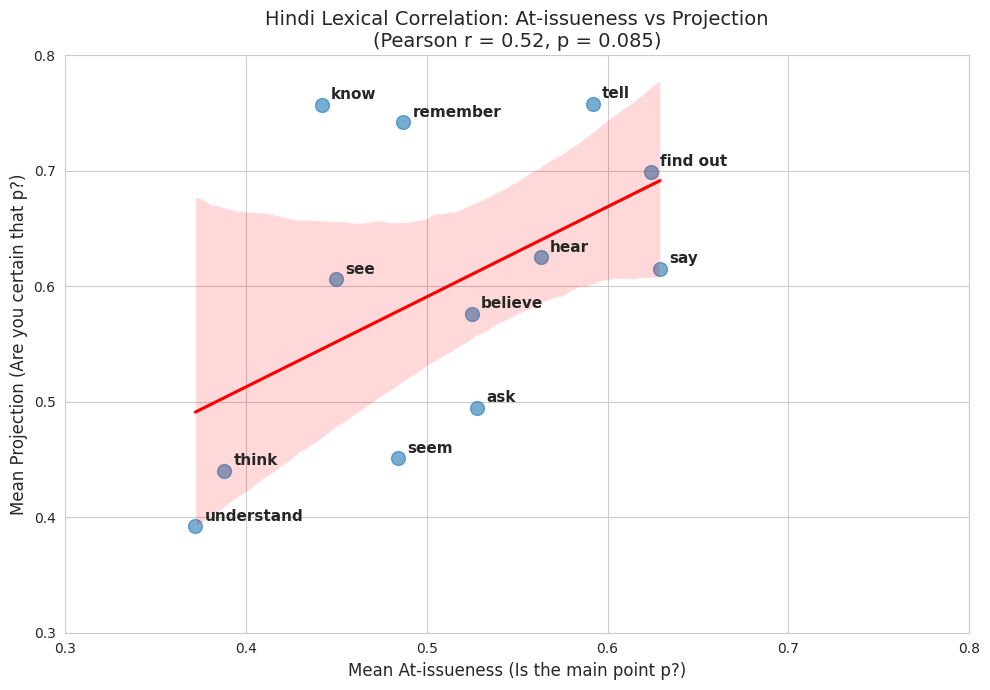

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 1. Create the data
data = {
    'Hindi Verb': ['बताना', 'जानना', 'याद होना', 'पता चलना', 'सुनना', 'कहना', 'देखना', 'मानना', 'पूछना', 'लगना', 'सोचना', 'समझना'],
    'English': ['tell', 'know', 'remember', 'find out', 'hear', 'say', 'see', 'believe', 'ask', 'seem', 'think', 'understand'],
    'Verb Type': ['non-factive', 'factive', 'factive', 'factive', 'factive', 'non-factive', 'factive', 'non-factive', 'non-factive', 'non-factive', 'non-factive', 'factive'],
    'Mean Projection': [0.758, 0.757, 0.742, 0.699, 0.625, 0.615, 0.606, 0.576, 0.495, 0.451, 0.440, 0.392],
    'Mean At-issueness': [0.592, 0.442, 0.487, 0.624, 0.563, 0.629, 0.450, 0.525, 0.528, 0.484, 0.388, 0.372]
}

df_plot = pd.DataFrame(data)

# 2. Calculate Correlation for the Title
r, p = pearsonr(df_plot['Mean At-issueness'], df_plot['Mean Projection'])

# 3. Setup the Plot
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Create the scatter plot with a regression line
ax = sns.regplot(data=df_plot, x='Mean At-issueness', y='Mean Projection',
                 scatter_kws={'s': 100, 'alpha': 0.6}, line_kws={"color": "red"})

# 4. Add labels for each point
for i in range(df_plot.shape[0]):
    plt.text(df_plot['Mean At-issueness'][i] + 0.005,
             df_plot['Mean Projection'][i] + 0.005,
             df_plot['English'][i],
             fontsize=11, weight='semibold')

# 5. Customize Axes and Title
plt.title(f'Hindi Lexical Correlation: At-issueness vs Projection\n(Pearson r = {r:.2f}, p = {p:.3f})', fontsize=14)
plt.xlabel('Mean At-issueness (Is the main point p?)', fontsize=12)
plt.ylabel('Mean Projection (Are you certain that p?)', fontsize=12)
plt.xlim(0.3, 0.8) # Adjusting limits to center the data
plt.ylim(0.3, 0.8)

# Add a diagonal line to show where "English GPP" would expect the data (top-left)
plt.tight_layout()
plt.show()

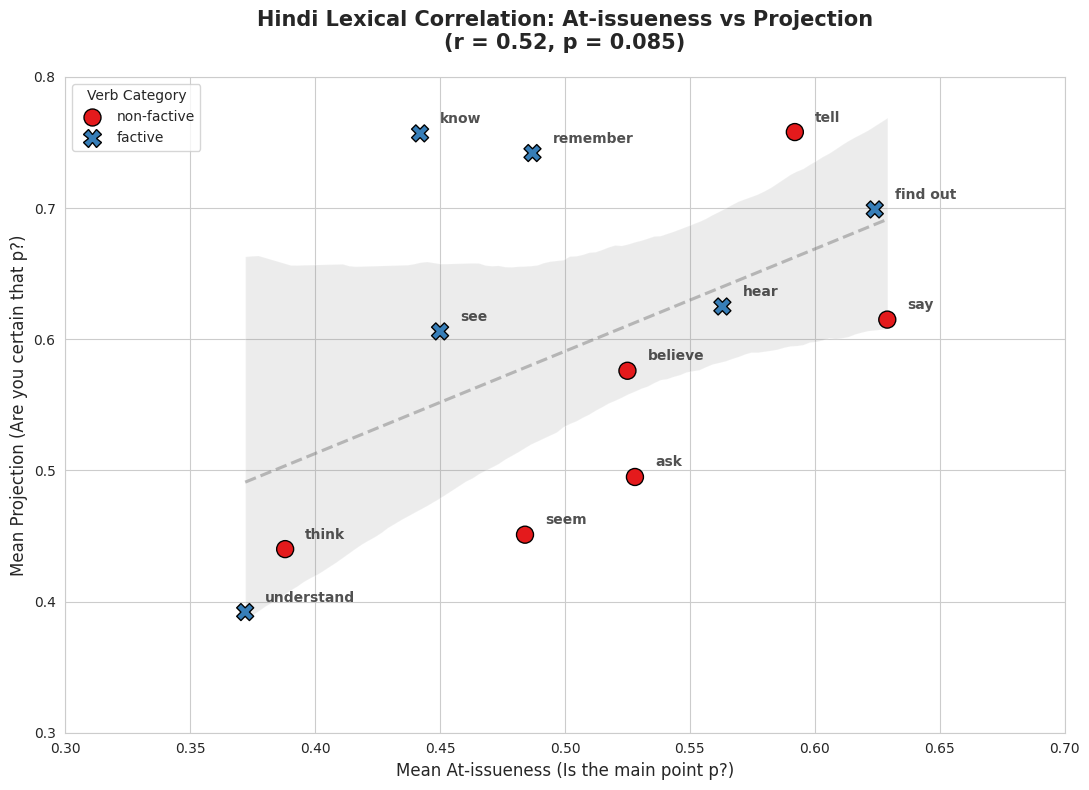

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 1. Input the summary table data
data = {
    'Hindi Verb': ['बताना', 'जानना', 'याद होना', 'पता चलना', 'सुनना', 'कहना', 'देखना', 'मानना', 'पूछना', 'लगना', 'सोचना', 'समझना'],
    'English': ['tell', 'know', 'remember', 'find out', 'hear', 'say', 'see', 'believe', 'ask', 'seem', 'think', 'understand'],
    'Verb Type': ['non-factive', 'factive', 'factive', 'factive', 'factive', 'non-factive', 'factive', 'non-factive', 'non-factive', 'non-factive', 'non-factive', 'factive'],
    'Mean Projection': [0.758, 0.757, 0.742, 0.699, 0.625, 0.615, 0.606, 0.576, 0.495, 0.451, 0.440, 0.392],
    'Mean At-issueness': [0.592, 0.442, 0.487, 0.624, 0.563, 0.629, 0.450, 0.525, 0.528, 0.484, 0.388, 0.372]
}

df_plot = pd.DataFrame(data)

# 2. Calculate Pearson Correlation for the Title
r, p = pearsonr(df_plot['Mean At-issueness'], df_plot['Mean Projection'])

# 3. Create the Visualization
plt.figure(figsize=(11, 8))
sns.set_style("whitegrid")

# Draw the regression line (overall trend)
sns.regplot(data=df_plot, x='Mean At-issueness', y='Mean Projection',
            scatter=False, color='gray', line_kws={"linestyle": "--", "alpha": 0.5})

# Draw the scatter points color-coded by Verb Type
sns.scatterplot(data=df_plot, x='Mean At-issueness', y='Mean Projection',
                hue='Verb Type', style='Verb Type', s=150, palette='Set1', edgecolor='black')

# 4. Annotate each point with its English translation
for i in range(df_plot.shape[0]):
    plt.text(df_plot['Mean At-issueness'][i] + 0.008,
             df_plot['Mean Projection'][i] + 0.008,
             df_plot['English'][i],
             fontsize=10, fontweight='bold', alpha=0.8)

# 5. Formatting the Plot
plt.title(f'Hindi Lexical Correlation: At-issueness vs Projection\n(r = {r:.2f}, p = {p:.3f})',
          fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Mean At-issueness (Is the main point p?)', fontsize=12)
plt.ylabel('Mean Projection (Are you certain that p?)', fontsize=12)

# Set limits to show the 0-1 scale clearly, zoomed into the data range
plt.xlim(0.3, 0.7)
plt.ylim(0.3, 0.8)

plt.legend(title='Verb Category', loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
pip install bambi arviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 17.7 MB/s eta 0:00:00


Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


--- Bayesian Model Summary ---
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
At_issueness  0.459  0.242    0.01    0.909      0.004    0.003    3130.0   

              ess_tail  r_hat  
At_issueness    2826.0    1.0  


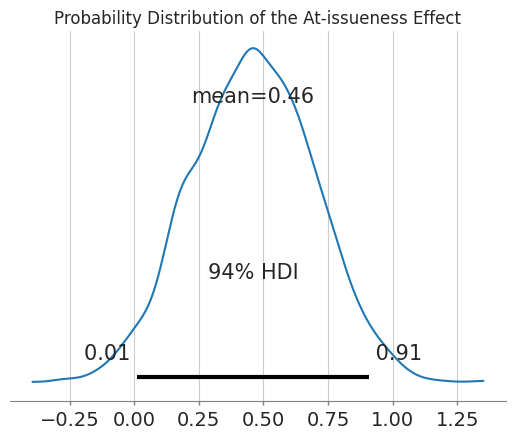

In [ ]:

import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

# 1. Load the data
df = pd.read_csv('Hindi_Transformed_Data_1.csv')

# 2. Prepare the "Wide" format
# To see if At-issueness predicts Projection, they must be in the same row
df_wide = df.pivot_table(index=['Participant_ID', 'Verb', 'Verb_Type'],
                          columns='Task_Block',
                          values='Rating_Beta').reset_index()

# Clean up column names (removing spaces/dashes for the formula)
df_wide.columns = ['Participant_ID', 'Verb', 'Verb_Type', 'At_issueness', 'Projection']

# 3. Define the Bayesian Mixed-Effects Beta Regression
# Formula: Projection is predicted by At-issueness.
# (1|Participant_ID): Each person gets their own baseline.
# (1|Verb): Each verb gets its own baseline.
model = bmb.Model(
    "Projection ~ At_issueness + (1|Participant_ID) + (1|Verb)",
    df_wide,
    family="beta"
)

# 4. Fit the model (This uses MCMC sampling)
# draws=2000: The number of "simulations" the AI runs to find the truth.
results = model.fit(draws=2000, tune=1000, target_accept=0.9)

# 5. Output the Results
print("--- Bayesian Model Summary ---")
summary = az.summary(results, var_names=["At_issueness"])
print(summary)

# 6. Visualize the "Posterior" (The probability distribution of your result)
az.plot_posterior(results, var_names=["At_issueness"])
plt.title("Probability Distribution of the At-issueness Effect")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os


INPUT_FILE = '/content/Hindi_Transformed_Data_2.csv'  # Your source file
OUTPUT_FILE = 'Hindi_Transformed_Data_1.csv' # Your target output file

def transform_ratings(input_path, output_path):
    # 1. Load the Data
    if not os.path.exists(input_path):
        print(f"❌ Error: Input file not found at {input_path}")
        return

    print(f"Loading data from {input_path}...")
    # Supports CSV or Excel
    if input_path.endswith('.xlsx'):
        df = pd.read_excel(input_path)
    else:
        df = pd.read_csv(input_path)

    # 2. Verify Sample Size (N)

    N = len(df)
    print(f"Dataset Size (N): {N}")

    # 3. Calculate Normalized Rating (0 to 1)

    df['Rating_Normalized'] = df['Rating'] / 100.0

    # 4. Calculate Beta Rating (Smithson & Verkuilen, 2006)
    # Formula: y' = [ y*(N-1) + 0.5 ] / N
    df['Rating_Beta'] = (df['Rating_Normalized'] * (N - 1) + 0.5) / N

    # 5. Format and Save

    columns_to_keep = [
        'Timestamp', 'Participant_ID', 'Verb', 'Verb_Type',
        'Task_Block', 'Rating', 'Rating_Normalized', 'Rating_Beta'
    ]

    # Check if all columns exist
    available_cols = [c for c in columns_to_keep if c in df.columns]
    final_df = df[available_cols]

    # Save to CSV
    final_df.to_csv(output_path, index=False)
    print(f"✅ Transformation complete.")
    print(f"   Beta ratings calculated using N={N}.")
    print(f"   File saved to: {output_path}")

# Run the transformation
if __name__ == "__main__":
    transform_ratings(INPUT_FILE, OUTPUT_FILE)

Loading data from /content/Hindi_Transformed_Data_2.csv...
Dataset Size (N): 552
✅ Transformation complete.
   Beta ratings calculated using N=552.
   File saved to: Hindi_Transformed_Data_1.csv
